In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import toeplitz

In [2]:
def gaussvector(mu, C, m):
    '''
    Generates a Gaussian random vector of length m given mean and covariance
    Arg:
        mu: Mean of random variable in the vector
        C: Covariance matrix of the random vector (nXn)
        m: The number of random gaussian vectors
    Returns:
        x: An n X m matrix of gaussian random vectors
    '''
    
    if (min(np.shape(C))==1 or len(np.shape(C))==1):
        #Checks if C is a vector and if so converts it to symmetric matrix
        C = toeplitz(C)
    
    n = np.shape(C)[1]
    
    if np.size(mu) == 1:
        mu = mu*np.ones((n,1))

    u,s,vh = np.linalg.svd(C)
    v = vh.T
        
    x = v@(np.diag(s)**0.5)@np.random.randn(n,m)+(mu@np.ones((1,m)))
    
    return x

In [33]:
def xsamplepath(y, T, cx, s):
    '''
    This function takes in a vector y of sampled from a Gaussian random vector coming from a Gaussian process
    with 0 mean and cov[k] = 1/(1+ak^2).
    
    It returns s Gaussian random vectors X which are the posterior distribution
    '''
    if (min(np.shape(cx))==1 or len(np.shape(cx))==1):
        #Checks if C is a vector and if so converts it to symmetric matrix
        Cxx = toeplitz(cx)
    
    #We need to find C_w|y and u_w|y
    #Get number of samples
    m = len(y)

    t = np.arange(0,m*T)
    
    #Generate list of time indices for W vector
    w_samps = np.asarray([n for n in t if (n+1)%T != 0]).reshape(m*T-m,1)

    #Generate list of time samples
    y_samps = np.arange(T-1, m*T, T).reshape(m, 1)
    
    #Selects all columns corresponding to time indices from Y
    A = np.zeros((m*T, m))
    for k in range(m):
        A[y_samps[k], k] = 1
    A = A.T
    
    #Selects all rows corresponding to time indices for W
    B = np.zeros((m*T-m, m*T))
    for j in range(m*T-m):
        B[j, w_samps[j]] = 1



    Cyy = A@Cxx@A.T
        

    Cww = B@Cxx@B.T
    

    Cwy = B@Cxx@A.T

    #Mean of w conditioned on y
    mu_w_y = Cwy @ np.linalg.inv(Cyy) @ y

    #Covaraince of w conditioned on y
    C_w_y = Cww - Cwy @ np.linalg.inv(Cyy) @ Cwy.T
    
    #Generate s sample paths of W
    W = gaussvector(mu_w_y,C_w_y,s)
    
    #Interpolates the values of from y vector back into X
    K = np.zeros((m*T,m*T-m))
    for p in range(m*T):
        if p in w_samps:
            col = np.where(w_samps == p)[0]
            K[p, col] = 1



    Y = y@np.ones((1,s))
    G = np.zeros((m*T,m))
    for g in range(m*T):
        if g in y_samps:
            col = np.where(y_samps == g)[0]
            G[g, col] = 1

    X = K@W + G@Y
    
    return X

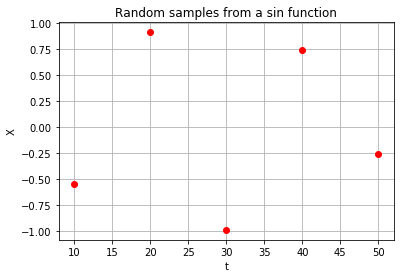

In [4]:
m = 5
T = 10
#Time indices for the Gaussian process of length mT
t = np.arange(0, m*T).reshape(m*T,1)

#Arbitrary specificed y from a sinusoid function
#the vector y samples x m times at [0, T, 2T, ..., (m-1)T]
y_indx = np.arange(T, m*T+T, T).reshape(m, 1)
y = np.sin(y_indx)

plt.plot(y_indx,y,'ro')
plt.grid()
plt.title("Random samples from a sin function")
plt.xlabel("t")
plt.ylabel("X")
plt.show()

In [28]:
# Generating y consistent with the covariance function
a = 1e-1
Cxx = 1/(1+a*t**2)
X = gaussvector(0, Cxx,1)

num_samples = np.size(X)
num_subsamples = num_samples//T

#Generates binary sampling matrix Y = AX 
A = np.zeros((num_subsamples,num_samples))
for i in range(A.shape[0]):
    if i*T+T-1 < A.shape[1]:
        A[i, i*T+T-1] = 1

y_cx = A@X

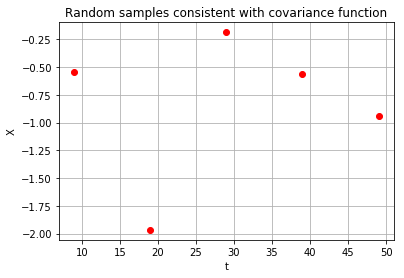

In [29]:
plt.plot(y_indx,y_cx,'ro')
plt.grid()
plt.title("Random samples consistent with covariance function")
plt.xlabel("t")
plt.ylabel("X")
plt.show()

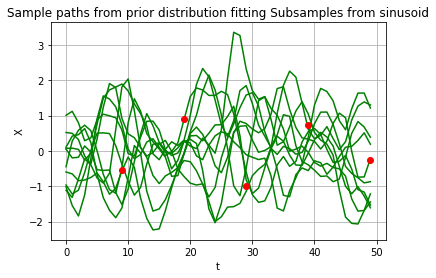

In [30]:
'''
As a sanity check lets generate sample paths from the prior distribution X without any information about y
and see how well it fits.

First we see how well it fits our y samples coming from the sine function.
'''
s = 10
X = gaussvector(0,Cxx,s)
plt.plot(t,X,'g')
plt.plot(y_indx,y,'ro')
plt.grid()
plt.title("Sample paths from prior distribution fitting Subsamples from sinusoid")
plt.xlabel("t")
plt.ylabel("X")
plt.savefig(fname='priorFitSine', dpi=300)
plt.show()

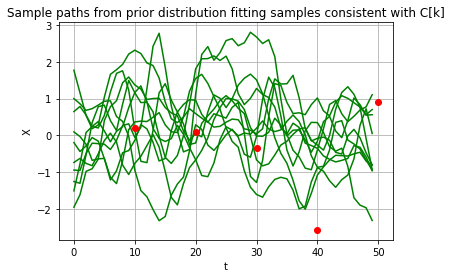

In [8]:
'''
Again but with the y that is consistent with out covariance function
'''
X = gaussvector(0,Cxx,s)

plt.plot(t,X,'g')
plt.plot(y_indx,y_cx,'ro')
plt.grid()
plt.title("Sample paths from prior distribution fitting samples consistent with C[k]")
plt.xlabel("t")
plt.ylabel("X")
plt.savefig(fname='priorFity_cov', dpi=300)
plt.show()

Here we see that plotting just the prior without any information about what we have observed results in sample paths that do not intersect with our points.

We will now construct our mean and covaraince for the posterior distribution and then generate sample paths from that to get sample paths that incorporate our "training" data.

## Finding $f_{w|y}$

So we have a stationary discrete Gaussian Process $X_{n}$ and we want to consider a sequence generated from this gaussian process ${X_{n}: n = 1, ...., T}$ with $E[X_{n}] = 0$ and covariance function $C_{X}[k] = E[X_{n}X_{n+k}]$. 

Now we have observed subsamples $X_{T},X_{2T},...,X_{mT}$ and we put this into a vector $Y = [X_{T},X_{2T},...,X_{mT}]$. Now lets consider the vector $W = [X_{0}, X_{1}, ...., X_{T-1}, X_{T+1},..., X{mT-1}]$ this has all the values from the generated sequence of the Gaussian process $X_{n}$ without any of the elements from $Y$.

Therefore $X = [W, Y]$ and thus $W$ and $Y$ are jointly Gaussian. Since this is the case we want to find $C_{w|y}$ and $\mu_{w|y}$ in order to generate gaussian random vectors $W$ and then impute the missing values into $W$ from $Y$ vector to get the "filled in" random vector $X$. We can find $C_{w|y}$ from theorem 1 and we can find $C_{wy}$ since all the elements of $w$ and $y$ are actually from the same Gaussian process.

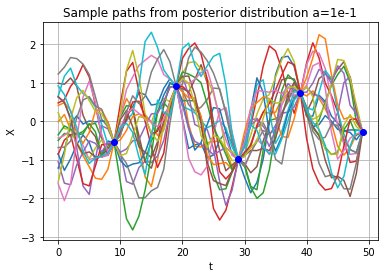

In [9]:
s = 20
a = 1e-1
T = 10
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)

Cxx = 1/(1+a*t**2)

X1 = xsamplepath(y, T, Cxx, s)


plt.plot(t, X1)
plt.plot(y_indx, y,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution a=1e-1')
#plt.savefig(fname = './posteriorFitSinea1e-1T10', dpi=300)
plt.show()

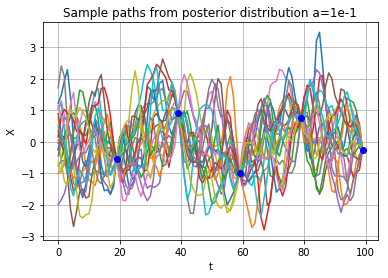

In [10]:
s = 20
a = 1e-1
T = 20
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)


Cxx = 1/(1+a*t**2)

X1 = xsamplepath(y, T, Cxx, s)


plt.plot(t, X1)
plt.plot(y_indx, y,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution a=1e-1')
#plt.savefig(fname = './posteriorFitSinea1e-1T20', dpi=300)
plt.show()

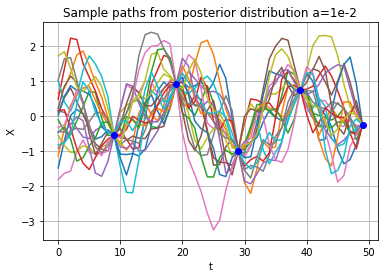

In [11]:
s = 20
a = 1e-1
T = 10
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)

Cxx = 1/(1+a*t**2)

X2 = xsamplepath(y, T, Cxx, s)


plt.plot(t, X2)
plt.plot(y_indx, y,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution a=1e-2')
#plt.savefig(fname = './posteriorFitSinea1e-2', dpi=300)
plt.show()

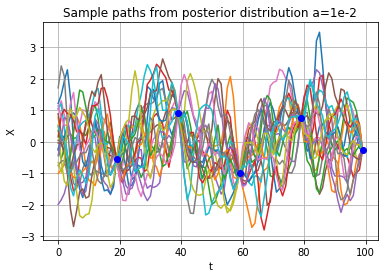

In [12]:
s = 20
a = 1e-2
T = 20
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)

Cxx = 1/(1+a*t**2)

X2 = xsamplepath(y, T, Cxx, s)


plt.plot(t, X1)
plt.plot(y_indx, y,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution a=1e-2')
#plt.savefig(fname = './posteriorFitSinea1e-2T20', dpi=300)
plt.show()

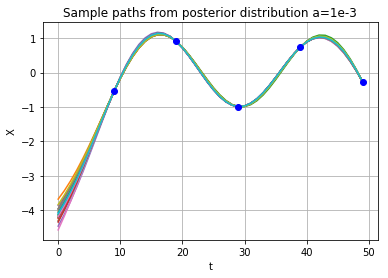

In [13]:
s = 20
a = 1e-3
T = 10
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)

Cxx = 1/(1+a*t**2)

X3 = xsamplepath(y, T, Cxx, s)

plt.plot(t, X3)
plt.plot(y_indx, y,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution a=1e-3')
#plt.savefig(fname = './posteriorFitSinea1e-3T10', dpi=300)
plt.show()

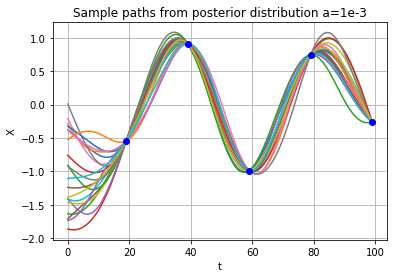

In [14]:
s = 20
a = 1e-3
T = 20
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)

Cxx = 1/(1+a*t**2)

X3 = xsamplepath(y, T, Cxx, s)


plt.plot(t, X3)
plt.plot(y_indx, y,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution a=1e-3')
#plt.savefig(fname = './posteriorFitSinea1e-3T20', dpi=300)
plt.show()

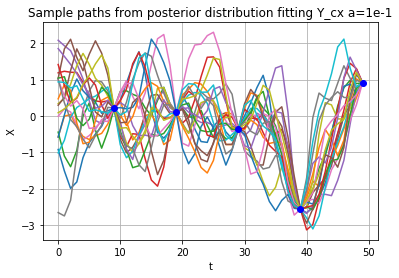

In [19]:
s = 20
a = 1e-1
T = 10
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)
Cxx = 1/(1+a*t**2)


X1 = xsamplepath(y_cx, T, Cxx, s)


plt.plot(t, X1)
plt.plot(y_indx, y_cx,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution fitting Y_cx a=1e-1')
plt.savefig(fname = './posteriorFitY_cxa1e-1T10', dpi=300)
plt.show()

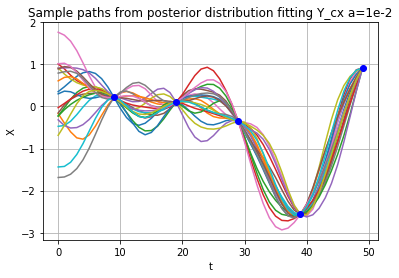

In [20]:
s = 20
a = 1e-2
T = 10
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)
Cxx = 1/(1+a*t**2)


X1 = xsamplepath(y_cx, T, Cxx, s)


plt.plot(t, X1)
plt.plot(y_indx, y_cx,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution fitting Y_cx a=1e-2')
plt.savefig(fname = './posteriorFitY_cxa1e-2T10', dpi=300)
plt.show()

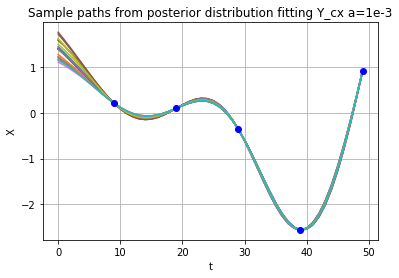

In [21]:
a = 1e-3
T = 10
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)
Cxx = 1/(1+a*t**2)


X1 = xsamplepath(y_cx, T, Cxx, s)


plt.plot(t, X1)
plt.plot(y_indx, y_cx,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution fitting Y_cx a=1e-3')
plt.savefig(fname = './posteriorFitY_cxa1e-3T10', dpi=300)
plt.show()

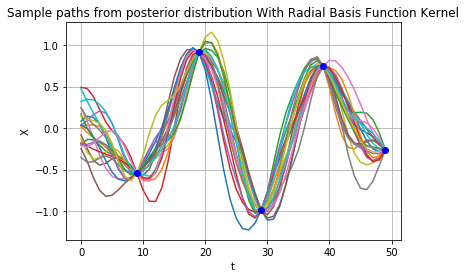

In [18]:
s = 20
T = 10
m = np.size(y)
t = np.arange(0,m*T)
ll = 1e-1
var = 1e-1
Cxx = var*np.exp(-(t**2)/2*ll)

X2 = xsamplepath(y, T, Cxx, s)

y_indx = np.arange(T-1,m*T,T)

plt.plot(t, X2)
plt.plot(y_indx, y,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution With Radial Basis Function Kernel')
#plt.savefig(fname = './posteriorFitSinea1e-2T20ExpKernel', dpi=300)
plt.show()

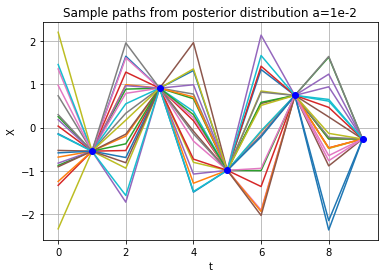

In [53]:
s = 20
a = 5
T = 2
m = np.size(y)
t = np.arange(0,m*T)
y_indx = np.arange(T-1,m*T,T)

Cxx = 1/(1+a*t**2)

X2,C_wy,C_w_y, mu_w_y = xsamplepath(y, T, Cxx, s)


plt.plot(t, X2)
plt.plot(y_indx, y,'bo')
plt.grid()
plt.xlabel('t')
plt.ylabel('X')
plt.title('Sample paths from posterior distribution a=1e-2')
#plt.savefig(fname = './posteriorFitSinea1e-2', dpi=300)
plt.show()

In [54]:
np.set_printoptions(precision=3)

print(C_w_y)

[[0.972 0.018 0.006 0.003 0.001]
 [0.018 0.947 0.016 0.005 0.002]
 [0.006 0.016 0.947 0.016 0.005]
 [0.003 0.005 0.016 0.947 0.016]
 [0.001 0.002 0.005 0.016 0.947]]


In [50]:
mu_w_y

array([[-0.28 ],
       [ 0.166],
       [-0.035],
       [-0.11 ],
       [ 0.214]])